# Iterative Surface Finding

In the first tutorial we used a very basic approach to finding the surface. We simply applied the method described by [Pinte et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018A%26A...609A..47P/abstract) to all the pixels with a large SNR and then tried to mask those pixels which made sense in the $(r,\, z)$ plane.

Here we apply a slightly different approach which we hope is more 'hands-free'. This employs an iterative approach where the previously defined surface, $z(r)$, and rotation curve, $v_{\phi}(r)$ are used to generate a mask for the extraction of a new surface. By repeating this process both $z(r)$ and $v_{\phi}(r)$ should converge to the correct result.

**NOTE** - Currently this method only works for the front side of the disk. An implementation for the back side is a work in progress.

To demonstrate this we'll use the DSHARP $^{12}$CO J=2-1 data for the disk around HD 163296, presented in [Isella et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018ApJ...869L..49I/abstract) and available from the [DSHARP website](https://almascience.eso.org/almadata/lp/DSHARP/), or using the following bit of code. Note that this is a bit of a chunky file (~1.6GB), so make sure you have space for it!

In [1]:
import os
if not os.path.exists('HD163296_CO.fits'):
    from wget import download
    download('https://almascience.eso.org/almadata/lp/DSHARP/images/HD163296_CO.fits')

We just need to import `observation` from `disksurf` and read in the cube. Note here you want to make sure that `velocity_rage` is broad enough that the edge channels (ideally 5) can be used to estimate the RMS.

In [2]:
from disksurf import observation

In [3]:
cube = observation('HD163296_CO.fits', FOV=10.0, velocity_range=[0.0e3, 12e3])

Define the general source properties that we need.

In [4]:
x0 = -2.8e-3 # arcsec
y0 = 7.7e-3  # arcsec
inc = 46.7   # deg
PA = 312.0   # deg
vlsr = 5.7e3 # m/s

Plot the channels to determine which ones we want to fit.

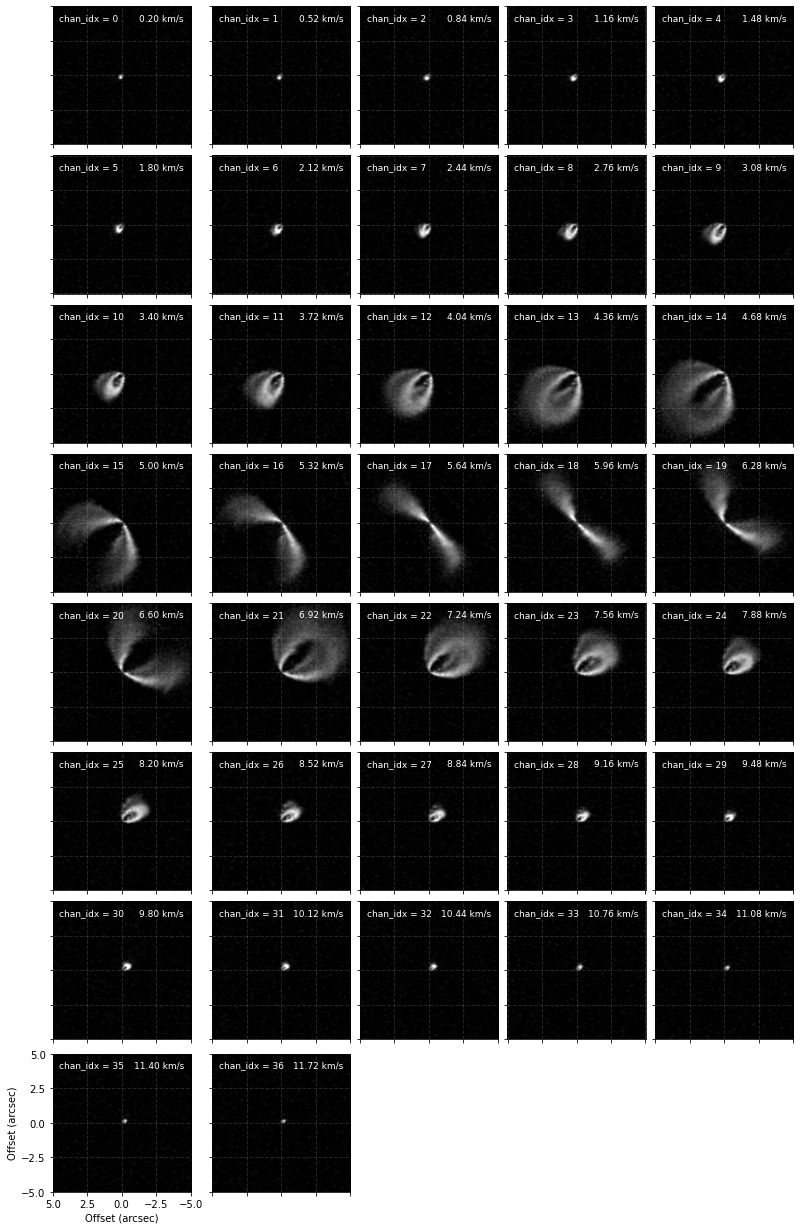

In [5]:
cube.plot_channels()

In [6]:
chans = [(9, 16), (19, 25)]

To begin with we run a first iteration. Here we want to be relatively free with the masking parameters here as the $(z,\,r)$ region defined by this first surface will limit where the following surfaces are found.

Here we use a very low `min_SNR=1.0` and `smooth=2.0`.

In [7]:
surface = cube.get_emission_surface(x0=x0, y0=y0, inc=inc, PA=PA, vlsr=vlsr,
                                    chans=chans, min_SNR=2.0, smooth=2.0)

Centering data cube...
Rotating data cube...
Detecting peaks...
Done!


As before we can plot the extracted surface and where the peaks were found to check that things make some sense.

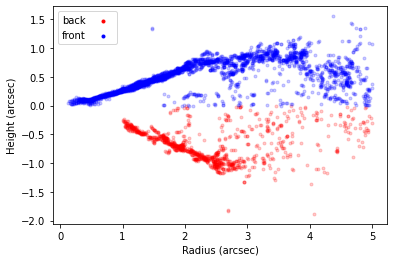

In [8]:
surface.plot_surface()

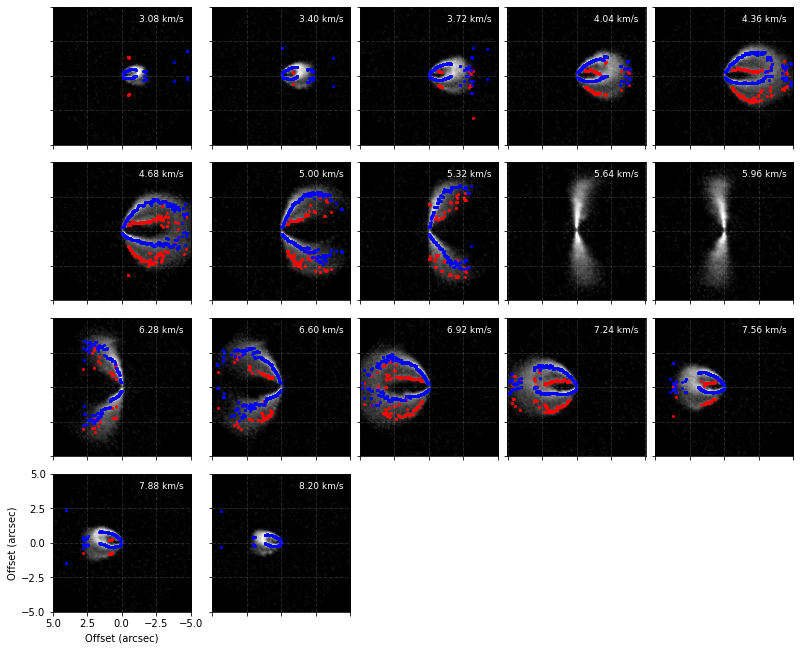

In [9]:
cube.plot_peaks(surface)

We can now use this surface as the first iteration using the `get_emission_surface_iterative` function. This requires a `surface` instance that it will use for the first iteration. You can then specify how many iterations you want to run with `N`, defaulting to 5, then for each iteration you can specify a `min_SNR` and how broad the mask should be about the model isovelocity contours in units of the beam FWHM with `nbeams`.

Both `min_SNR` and `nbeams` can either be single values which would be used for all iterations, or a list specifying a different value for each iteration.

In [10]:
iter_surface = cube.get_emission_surface_iterative(surface, N=5, nbeams=1.0,
                                                   min_SNR=[1.0, 1.0, 2.0, 2.0, 5.0])

Running iteration 1/5...
Calculating masks...
Detecting peaks...
Done
Running iteration 2/5...
Calculating masks...
Detecting peaks...
Done
Running iteration 3/5...
Calculating masks...
Detecting peaks...
Done
Running iteration 4/5...
Calculating masks...
Detecting peaks...
Done
Running iteration 5/5...
Calculating masks...
Detecting peaks...
Done


This new `surface` can be used just as any other surface. You can clearly see the improvement the surface has made in defining the peaks when you compare that to the inital surface.

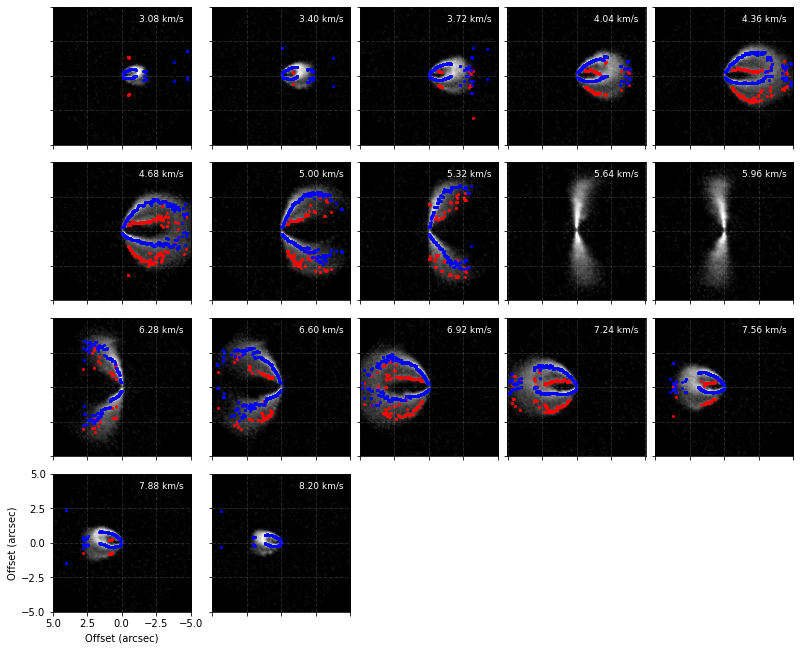

In [11]:
# original surface
cube.plot_peaks(surface=surface)

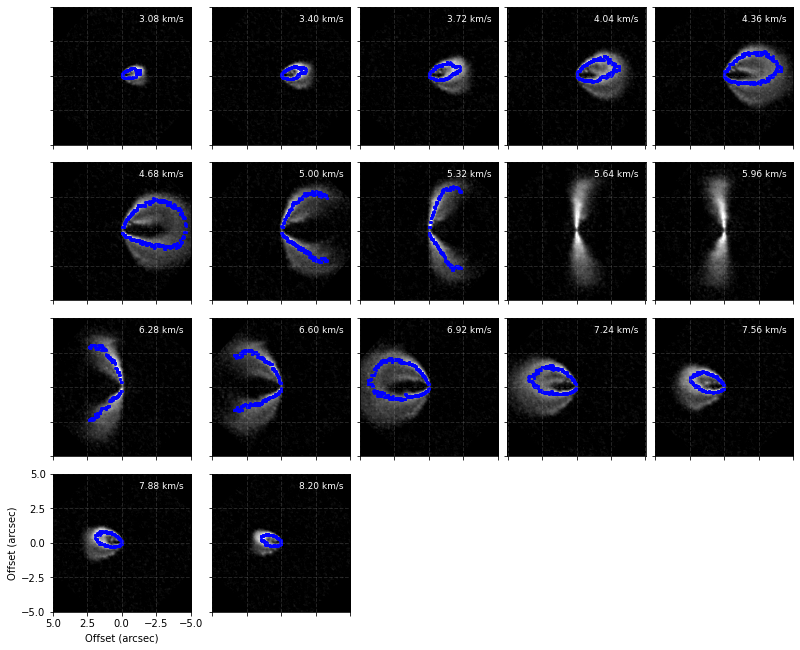

In [12]:
# improved surface
cube.plot_peaks(surface=iter_surface)

To see how the masks are being used you can use the `plot_mask` function from `observation` which will plot the 'near side' and 'far side' masks used for the fitting.

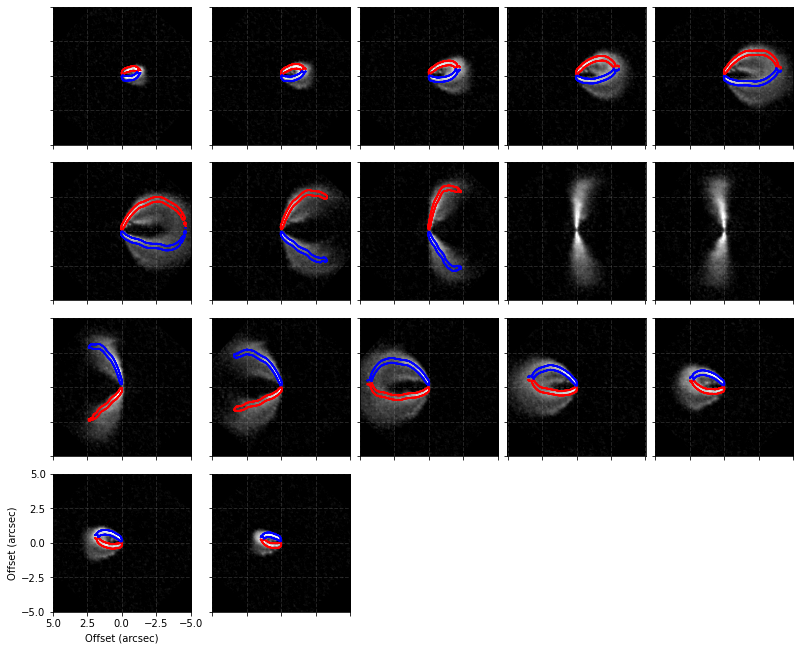

In [13]:
cube.plot_mask(surface=iter_surface)

This surface also provides an improvement in the derived $T_b(r,\,z)$ structure too.

(-0.15, 5.15)

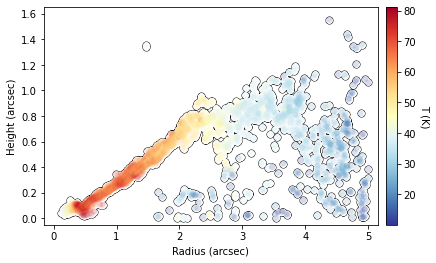

In [14]:
# original surface
fig = cube.plot_temperature(surface=surface, side='front', return_fig=True)
fig.axes[0].set_ylim(-0.05, 1.65)
fig.axes[0].set_xlim(-0.15, 5.15)

(-0.15, 5.15)

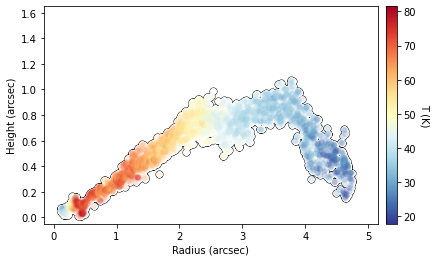

In [15]:
# improved surface
fig = cube.plot_temperature(surface=iter_surface, return_fig=True)
fig.axes[0].set_ylim(-0.05, 1.65)
fig.axes[0].set_xlim(-0.15, 5.15)